In [25]:
import csv
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import calendar

# When importing from Google Docs

Download as `.tsv` and, if needed, remove incomplete trips from the bottom of the tile.

Remove the first header row.

In [2]:
class Summit(object):
    def __init__(self, row):
        self.name = row['Summit']
        date = datetime.datetime.strptime(row['Date'], '%m-%d-%Y').date()
        self.date = date
    
    def __str__(self):
        return self.name
    
    def __hash__(self):
        return hash( str(self) )
    
    def __repr__(self):
        return str(self)
    

class Trip(object):
    def __init__(self, row):
        self.name     = row['Name']
        self.days     = int(row['Days'])
        self.nights   = int(row['Nights'])
        self.miles    = float(row['Miles'])
        self.vert     = int(row['Vertical'])
        self.partners = set()
        self.solo     = row['Solo?'] == 'TRUE'
        self.summits  = set()
        
        for partner in row['Partners'].split(','):
            if len(partner.strip()) > 0:
                self.partners.add( partner.strip() )
            
    def __hash__(self):
        return hash( str(self) )
    
    def __str__(self):
        return self.name
    
    def add_summit(self, row):
        self.summits.add( Summit(row) )
    
    def steepness(self):
        ''' number of vertical feet per mile '''
        return self.vert/self.miles
    
    def summits_pretty(self):
        return '[' + ', '.join(map(str, self.summits)) + ']'
    

In [3]:
trips = set()

with open('bulger_trips.tsv')  as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t')
    
    current_trip = None
    summits = 0
    for row in reader:
        if row['Name'] != '':
            if current_trip is not None:
                trips.add(current_trip)
                trips
            current_trip = Trip(row)
        
        elif row['Summit'] != '':
            current_trip.add_summit(row)
            summits += 1
    
    # don't want to miss the last trip
    trips.add(current_trip)

print( 'Finished loading {} trips with {} summits.'.format(len(trips), summits) )

Finished loading 57 trips with 98 summits.


In [20]:
summits = []

for t in trips:
    for s in t.summits:
        summits.append(s)
        
print( "Computed {} summits.".format(len(summits)) )
        
        
summits.sort(key=lambda s: s.date)

Computed 98 summits.


# Trips

## The basics

In [5]:
print( "{} trips, {} summits.".format(len(trips), len(summits)) )
total_distance = 0
total_vert = 0
total_days = 0
total_nights = 0

for t in trips:
    total_distance += t.miles
    total_vert += t.vert
    total_days += t.days
    total_nights += t.nights
    
print( "{} miles, with {:,} feet of climbing.".format(total_distance, total_vert) )

print( "{} days of hiking, {} nights of camping.".format(total_days, total_nights) )



57 trips, 98 summits.
1145.48 miles, with 528,557 feet of climbing.
142 days of hiking, 104 nights of camping.


## ... by distance

In [6]:
for t in sorted(trips, key=lambda trip: trip.miles, reverse=True):
    print("{:<80}{:6.2f}".format(t.summits_pretty(), t.miles))

[Mt. Lago, Lost Peak, Ptarmigan Peak, Blackcap Mountain]                         48.95
[Remmel Mountain, Amphitheater Mountain, Cathedral Peak]                         44.85
[Chiwawa Mountain]                                                               42.58
[Sinister Peak, Dome Peak]                                                       37.20
[Storm King, Goode Mountain]                                                     36.00
[Cardinal Peak, Saska Peak, Pinnacle Mountain, Emerald Peak]                     33.40
[Glacier Peak]                                                                   32.92
[Flora Mountain, Tupshin Peak, Devore Peak]                                      32.84
[Kimtah Peak, Mt. Logan, Cosho Peak]                                             31.12
[Azurite Peak]                                                                   30.95
[Mt. Custer, Mt. Spickard, Mt. Rahm, Mt. Redoubt]                                29.83
[Mox Peaks,SE Spire, Mox Peaks,NW Spire]   

## ... by vertical

In [7]:
for t in sorted(trips, key=lambda trip: trip.vert, reverse=True):
    print("{:<80}{:7,}".format(t.summits_pretty(), t.vert))

[Mt. Lago, Lost Peak, Ptarmigan Peak, Blackcap Mountain]                         19,630
[Kimtah Peak, Mt. Logan, Cosho Peak]                                             17,938
[Mt. Fernow, South Spectacle Butte]                                              16,335
[Mt. Custer, Mt. Spickard, Mt. Rahm, Mt. Redoubt]                                16,133
[Flora Mountain, Tupshin Peak, Devore Peak]                                      15,800
[Cardinal Peak, Saska Peak, Pinnacle Mountain, Emerald Peak]                     15,574
[Mox Peaks,SE Spire, Mox Peaks,NW Spire]                                         13,609
[Monument Peak, Lake Mountain]                                                   13,607
[Chiwawa Mountain]                                                               13,431
[Glacier Peak]                                                                   13,023
[Remmel Mountain, Amphitheater Mountain, Cathedral Peak]                         12,620
[Klawatti Peak, Dorado Needle]  

## ... and by steepness

In [8]:
for t in sorted(trips, key=lambda trip: trip.steepness(), reverse=True):
    print("{:<80}{:02.0f} vert. ft./mi.".format(t.summits_pretty(), t.steepness()))

[Sahale Mountain]                                                               896 vert. ft./mi.
[Copper Peak]                                                                   867 vert. ft./mi.
[Forbidden Peak]                                                                864 vert. ft./mi.
[Black Peak]                                                                    861 vert. ft./mi.
[Klawatti Peak, Dorado Needle]                                                  831 vert. ft./mi.
[Silver Star Mountain]                                                          758 vert. ft./mi.
[Big Craggy Peak, West Craggy]                                                  739 vert. ft./mi.
[Big Snagtooth]                                                                 717 vert. ft./mi.
[Eldorado Peak, Austera Peak]                                                   660 vert. ft./mi.
[Mt. Fernow, South Spectacle Butte]                                             655 vert. ft./mi.
[Robinson Mountain] 

# Partners

In [10]:
partners_summits = defaultdict(set)
partner_stats = defaultdict(lambda: {'vert':0, 'days':0, 'nights':0, 'miles':0})

for t in trips:
    for s in t.summits:
        if not t.solo:
            for p in t.partners:
                partners_summits[p].add(s)
        else:
            partners_summits['Solo'].add(s)
            
    for p in t.partners:
        partner_stats[p]['vert']   += t.vert
        partner_stats[p]['days']   += t.days
        partner_stats[p]['nights'] += t.nights
        partner_stats[p]['miles']  += t.miles

In [11]:
print( "{:<15}{}".format("PARTNER", "PEAKS"))

trim_len = 130

for partner, summits in sorted(partners_summits.items(), key=lambda x: len(x[1]), reverse=True):
    pretty_summits = '    [' + ", ".join( map(str, summits) ) + ']'
    if len(pretty_summits) > trim_len:
        pretty_summits = pretty_summits[:trim_len] + '...'
    print( "{:<15}{:2d}".format(partner, len(summits)) + pretty_summits )

PARTNER        PEAKS
Dan            41    [Clark Mountain, Copper Peak, Mt. Shuksan, Katsuk Peak, Dark Peak, Fortress Mountain, Devore Peak, Bonanza Peak, Storm King, M...
Solo           27    [Saska Peak, Switchback Peak, Emerald Peak, Courtney Peak, Hoodoo Peak, Lost Peak, Cannon Mountain, McClellan Peak, Mt. Logan,...
Adam           17    [Mt. Buckner, Sherpa Peak, Forbidden Peak, Mt. Stuart, Enchantment Peak, Mt. Spickard, Mt. Maude, Fortress Mountain, Mt. Custe...
Margaret       12    [Mt. Maude, Bonanza Peak, Clark Mountain, Seven Fingered Jack, Austera Peak, Luahna Peak, Fortress Mountain, Black Peak, Marti...
Addison         7    [Glacier Peak, Primus Peak, Cathedral Peak, Mt. St. Helens, Mt. Formidable, Remmel Mountain, Amphitheater Mountain]
Duncan          4    [Big Craggy Peak, Silver Star Mountain, West Craggy, Little Tahoma]
Becca           4    [Klawatti Peak, Mt. Fernow, South Spectacle Butte, Dorado Needle]
Ellie           3    [Clark Mountain, Chiwawa Mountain, Luahna

In [12]:
print( "{:<15}{:>10}{:>10}{:>10}{:>10}".format( "PARTNER", "VERTICAL", "DAYS", "NIGHTS", "MILES") )


for partner, s in sorted(partner_stats.items(), key=lambda x: x[1]['vert'], reverse=True):
    print( "{:<15}{:10,d}{:10,d}{:10,d}{:10.0f}".format(partner, s['vert'], s['days'], s['nights'], s['miles']) )

PARTNER          VERTICAL      DAYS    NIGHTS     MILES
Dan               244,031        77        55       523
Adam               91,398        25        17       176
Margaret           77,500        31        23       169
Addison            53,267        11         8       125
Cameron            29,605         6         5        61
Becca              28,948         7         6        40
Ellie              23,731         9         7        68
Duncan             19,588         5         4        32
Sean               13,240         2         2        28
Alex                8,995         2         1        18
Marco               7,746         2         1        22
Erica               6,910         2         1        11
Leah                6,252         3         3         7


# Time

## Months

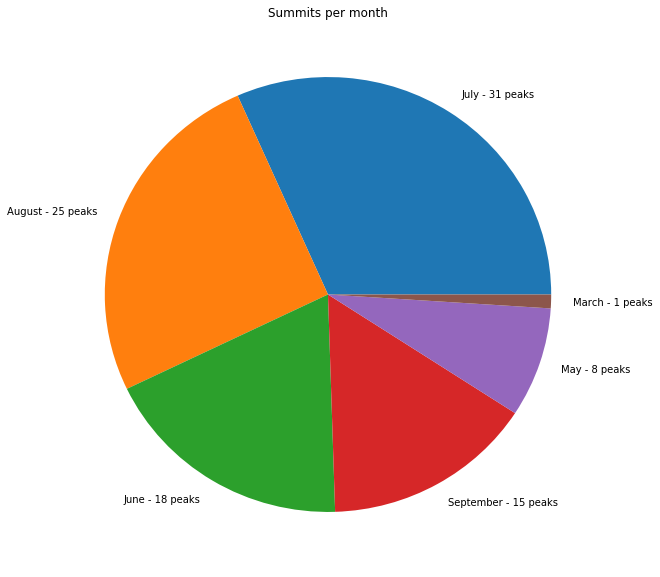

In [13]:
plt.figure(figsize=(10,10))

summits_per_month = defaultdict(int)

for t in trips:
    for s in t.summits:
        summits_per_month[ datetime.datetime.strftime(s.date, '%B') ] += 1
        

summits_per_month = [(count, "{} - {} peaks".format(month, count)) for month, count in summits_per_month.items()]
summits_per_month.sort(key=lambda s: s[0], reverse=True)
        
plt.pie(zip(*summits_per_month)[0], labels=zip(*summits_per_month)[1])
plt.title('Summits per month')
plt.show()

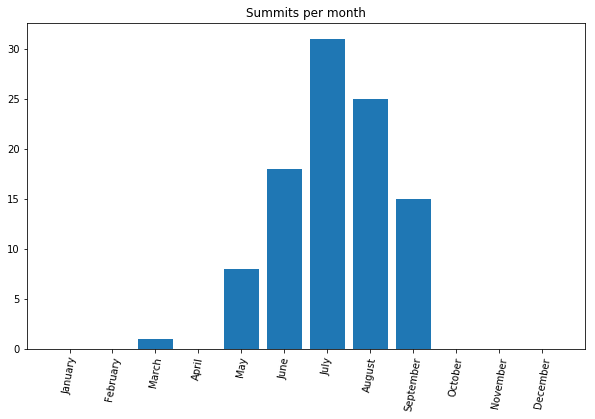

In [14]:
plt.figure(figsize=(10,6))

summits_per_month = defaultdict(int)

for t in trips:
    for s in t.summits:
        summits_per_month[ datetime.datetime.strftime(s.date, '%B') ] += 1
        
bars, labels = [], []
for month in range(1,13):
    month_pretty = datetime.datetime.strftime(datetime.date(year=2019, month=month, day=1), '%B')
    labels.append(month_pretty)
    bars.append( summits_per_month[month_pretty] )

plt.bar(range(1,13), bars)
plt.xticks(range(1,13), labels, rotation=80)
plt.title('Summits per month')
plt.show()

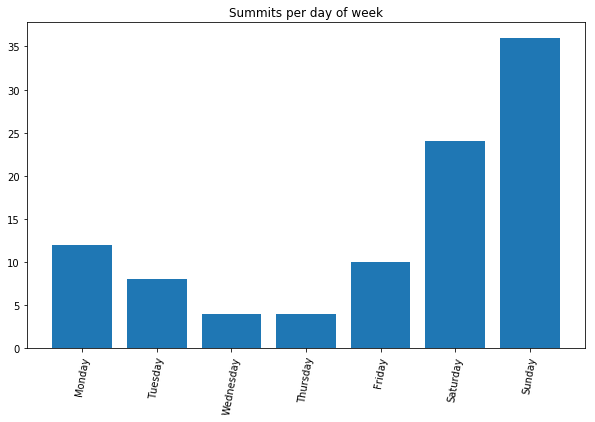

In [37]:
plt.figure(figsize=(10,6))

summits_per_weekday = defaultdict(int)

for s in summits:
    summits_per_weekday[ datetime.datetime.strftime(s.date, '%A') ] += 1
        
bars, labels = [], []
for i, day_name in enumerate(calendar.day_name):
    labels.append(day_name)
    bars.append( summits_per_weekday[day_name] )

plt.bar(range(7), bars)
plt.xticks(range(7), labels, rotation=80)
plt.title('Summits per day of week')
plt.show()

# Progress over time

# summits per year

In [22]:
summits_per_year = defaultdict(int)

for s in summits:
    summits_per_year[ s.date.year ] += 1
        
for year, count in sorted(summits_per_year.items(), key=lambda x: x[0]):
    print( "{} {}".format(year, count) )

2005 1
2006 1
2007 2
2008 2
2009 1
2010 6
2011 3
2012 4
2013 3
2014 3
2015 12
2016 13
2017 12
2018 13
2019 22


In [23]:
finished_so_far = 0
amount_complete_by_day = {}

for s in summits:
    finished_so_far += 1
    amount_complete_by_day[s.date] = finished_so_far

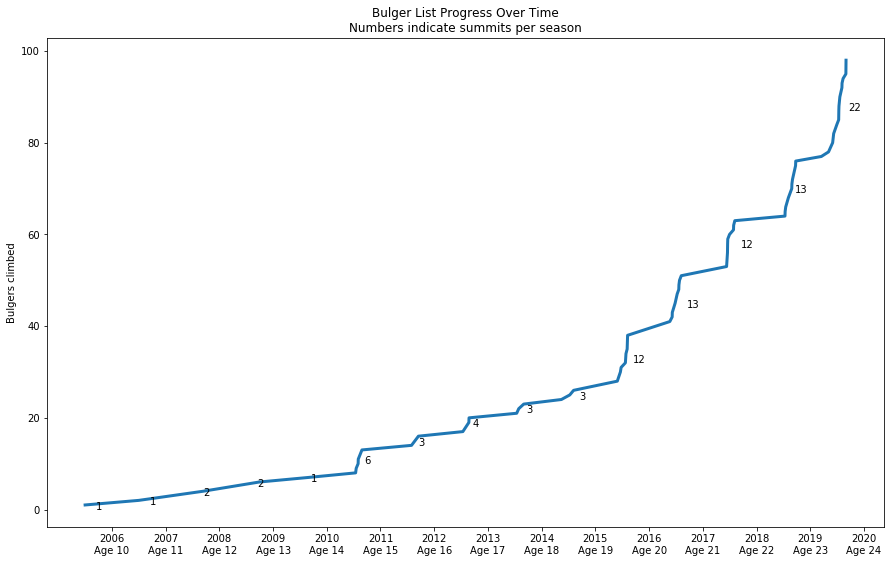

In [24]:
plt.figure(figsize=(15,9))


xs = []
ys = []

for date, count in sorted(amount_complete_by_day.items(), key=lambda x: x[1]):
    ys.append(count)
    xs.append( (date - summits[0].date).days )
    
plt.plot(xs, ys, linewidth=3)
plt.ylabel("Bulgers climbed")
ticks = []
labels = []
for year in range(2006, 2021):
    #for month in (1, 3, 6, 9, 12):
    for month in (1,):
        date = datetime.date(year=year, month=month, day=1)
        tick = (date - summits[0].date).days
        ticks.append(tick)
        label = datetime.datetime.strftime(date, '%Y') + "\nAge {}".format( (date - datetime.date(day=22, month=10, year=1995)).days/365 )
        labels.append(label)
plt.xticks(ticks, labels)

finished_so_far = 0
for year, count in sorted(summits_per_year.items(), key=lambda x: x[0]):
    date = datetime.date(year=year, month=9, day=15)
    x = (date - summits[0].date).days
    y = finished_so_far + count/2
    finished_so_far += count
    
    plt.text(x,y,str(count))


plt.title("Bulger List Progress Over Time\nNumbers indicate summits per season")
plt.show()